# CSCI1951Z: Final Auditing Project

**Notebook Overivew:** This notebook contains the code for generating data and analyzing the results from Bold Bank's hiring algorithm. The results from this analysis are discussion in detail within the findings report also included in this repo.

In [1]:
# import necessary libraries 
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import ttest_ind, chi2_contingency

## Generating data points

**Section Overview:** The below section is used to generate 4000 datapoints that represent 4000 unique candidates. Each candidate is comprised of various sensative features, including gender, ethnicity, and disability status. These datapoints will ultimately be used to query Bold Bank's hiring algorithm and assess for bias.

In [2]:
# potential schools for datapoints 
schools = ['Brown University', 'Columbia University', 'SUNY Binghamton University', 'SUNY New Paltz',
           'Providence College','Rhode Island School of Design', 'Bentley University', 'Colgate University']

# potential gpas for datapoints 
gpa = np.arange(1.2,4.1,0.1,dtype=float)

# degree options for datapoints 
degrees = ['Bachelors','Masters','Phd']

# potential locations for datapoints 
locations = ['Providence','Boston','New York City','Los Angeles','Miami','Chicago', 'Detroit', 'Washington D.C.']

# potential genders 
gender = ['M', 'F', 'N/A']

# potential veteran status 
veteran = ['0','1','N/A']

# potential work authorization
work_ath = ['0','1']

# potential value for disability 
disability = ['0','1','N/A']

# potential ethnicities 
ethnicity = ['0','1','2','3','4']

# potential roles 
roles = ['Junior SWE', 'Senior SWE','Data scientist','Lawyer','ML Engineer','N/A', 'Chef','Bus Driver']

# master list for all attributes not include roles 
candidate_atts = [schools, gpa, degrees, locations, gender, veteran, work_ath, disability, ethnicity]

# columns for dataframe 
COLUMNS = ['School Name','GPA','Degree','Location','Gender',
        'Veteran status','Work authorization','Disability','Ethnicity',
        'Role 1', 'Start 1', 'End 1','Role 2','Start 2','End 2','Role 3','Start 3','End 3']


In [3]:
import numpy as np
import pandas as pd

MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
COLUMNS = ['School Name', 'GPA', 'Degree', 'Location', 'Gender',
           'Veteran status', 'Work authorization', 'Disability', 'Ethnicity',
           'Role 1', 'Start 1', 'End 1', 'Role 2', 'Start 2', 'End 2', 'Role 3', 'Start 3', 'End 3']

# function to generate data points 
def generate_data(n_samples: int, candidate_atts: list, roles: list, random_seed: int) -> pd.DataFrame:
    np.random.seed(random_seed)
    all_candidates = []  # List for all datapoints

    # Generate for each datapoint
    for i in range(n_samples):
        candidate = [i + 1]  # New candidate starting with Applicant ID

        # Loop through each attribute type for given candidate
        for attribute in candidate_atts:
            # Pick random attribute from list
            candidate.append(attribute[np.random.randint(0, len(attribute))])

        # Generate role types
        cand_roles = [roles[np.random.randint(0, len(roles))] for _ in range(3)]
        role_history = []  # Candidates job history

        # Loop through candidate roles to populate dates
        for index, role in enumerate(cand_roles):
            if role == 'N/A':
                while len(role_history) != 9:
                    role_history.append('N/A')
                break
            else:
                start_month = MONTHS[np.random.randint(0, len(MONTHS))]
                end_month = start_month  # Initialize end_month same as start_month

                start_year = np.random.randint(10, 24)
                range_high = 23 - start_year
                if range_high <= 0:  # Safeguard against low >= high
                    end_year = 23  # Set to max year if no range is available
                else:
                    end_year = start_year + np.random.randint(0, range_high)

                # If the start year equals the end year, adjust the end month to be after the start month
                if start_year == end_year:
                    if start_month == 12:  # Special case where start month is December
                        end_month = 1
                        end_year += 1  # Increment the year if end month cannot be later
                    else:
                        end_month = np.random.randint(start_month + 1, 13)

                start = f"{start_month}/{start_year}"
                if index == 0 and np.random.rand() < 0.1:  # 10% chance to end as 'N/A'
                    end = 'N/A'
                else:
                    end = f"{end_month}/{end_year}"

                role_history.append(role)
                role_history.append(start)
                role_history.append(end)

        candidate.extend(role_history)
        all_candidates.append(candidate)

    # Insert columns including Applicant ID at the start
    columns_with_id = ['Applicant ID'] + COLUMNS
    df = pd.DataFrame(all_candidates, columns=columns_with_id)

    return df

# Generate the DataFrame
df = generate_data(4000, candidate_atts, roles, 1951)

In [4]:
# display dataset of generated points 
df

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,Role 1,Start 1,End 1,Role 2,Start 2,End 2,Role 3,Start 3,End 3
0,1,Rhode Island School of Design,3.1,Bachelors,Miami,M,1,0,0,2,ML Engineer,7/16,7/22,Junior SWE,11/19,11/22,Senior SWE,12/21,12/22
1,2,Bentley University,1.9,Phd,New York City,N/A,0,0,1,0,Bus Driver,11/13,11/18,ML Engineer,11/14,12/14,N/A,N/A,N/A
2,3,SUNY New Paltz,1.7,Masters,Washington D.C.,M,1,1,1,1,Data scientist,4/22,6/22,N/A,N/A,N/A,N/A,N/A,N/A
3,4,Brown University,2.8,Bachelors,Los Angeles,F,1,0,1,2,Senior SWE,6/22,11/22,Lawyer,1/12,4/12,Lawyer,8/13,8/14
4,5,SUNY Binghamton University,2.8,Masters,Los Angeles,N/A,1,1,N/A,4,Lawyer,6/11,N/A,Junior SWE,6/10,7/10,Junior SWE,7/23,10/23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,Rhode Island School of Design,2.3,Masters,Detroit,F,1,0,N/A,0,ML Engineer,3/15,3/18,Lawyer,5/21,5/22,N/A,N/A,N/A
3996,3997,SUNY Binghamton University,1.6,Phd,Providence,N/A,0,0,N/A,0,Lawyer,10/17,10/18,Data scientist,5/21,5/22,Junior SWE,5/16,5/22
3997,3998,SUNY New Paltz,1.2,Bachelors,New York City,F,0,1,N/A,4,Chef,8/10,8/17,N/A,N/A,N/A,N/A,N/A,N/A
3998,3999,Brown University,1.8,Bachelors,Washington D.C.,N/A,0,1,1,4,Bus Driver,1/16,1/20,Chef,9/11,9/13,Senior SWE,9/14,9/22


In [5]:
# # save data to local drive
# csv_file_path = '../data/candidate_data_4000.csv'  
# df.to_csv(csv_file_path, index=False)

## Exploratoy Data Analysis

**Section Overview:** The below section contains an analysis of the datapoints that were generated in the above. This exploratory data analysis helps to confirm that the dataset is balanced across sensative attributes, which is key to our audit procedures.

In [6]:
# high level statistics of the continuous variables in dataset 
df.describe()

,Applicant ID,GPA
count,4000.000000,4000.000000
mean,2000.500000,2.572025
std,1154.844867,0.825073
min,1.000000,1.200000
25%,1000.750000,1.900000
50%,2000.500000,2.600000
75%,3000.250000,3.300000
max,4000.000000,4.000000


In [7]:
# types and fills of data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Applicant ID        4000 non-null   int64  
 1   School Name         4000 non-null   object 
 2   GPA                 4000 non-null   float64
 3   Degree              4000 non-null   object 
 4   Location            4000 non-null   object 
 5   Gender              4000 non-null   object 
 6   Veteran status      4000 non-null   object 
 7   Work authorization  4000 non-null   object 
 8   Disability          4000 non-null   object 
 9   Ethnicity           4000 non-null   object 
 10  Role 1              4000 non-null   object 
 11  Start 1             4000 non-null   object 
 12  End 1               4000 non-null   object 
 13  Role 2              4000 non-null   object 
 14  Start 2             4000 non-null   object 
 15  End 2               4000 non-null   object 
 16  Role 3

In [8]:
df.isnull().sum()

Applicant ID          0
School Name           0
GPA                   0
Degree                0
Location              0
Gender                0
Veteran status        0
Work authorization    0
Disability            0
Ethnicity             0
Role 1                0
Start 1               0
End 1                 0
Role 2                0
Start 2               0
End 2                 0
Role 3                0
Start 3               0
End 3                 0
dtype: int64

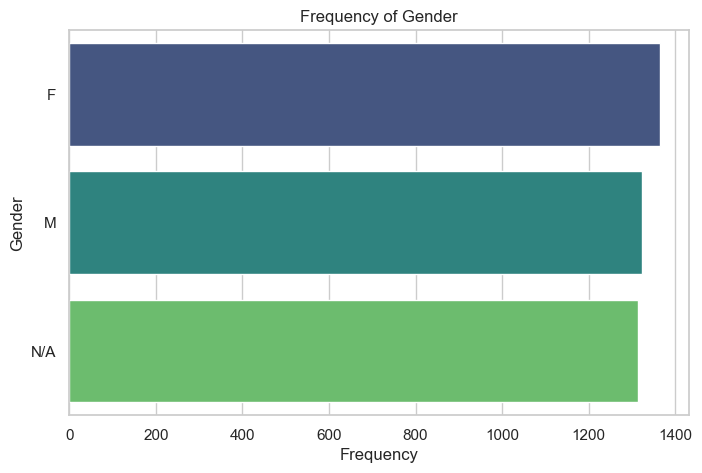

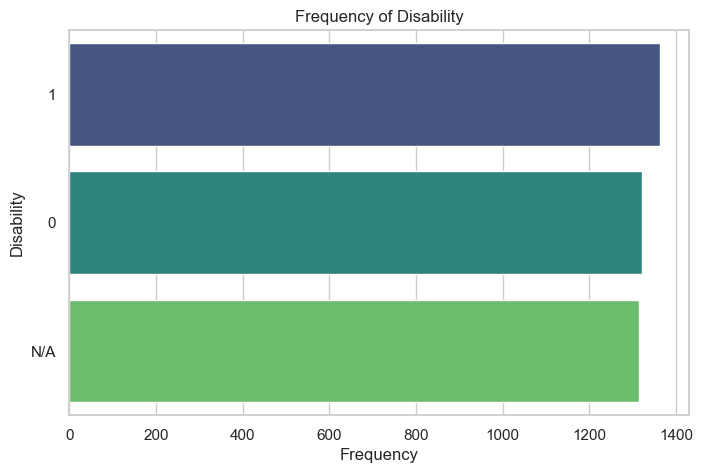

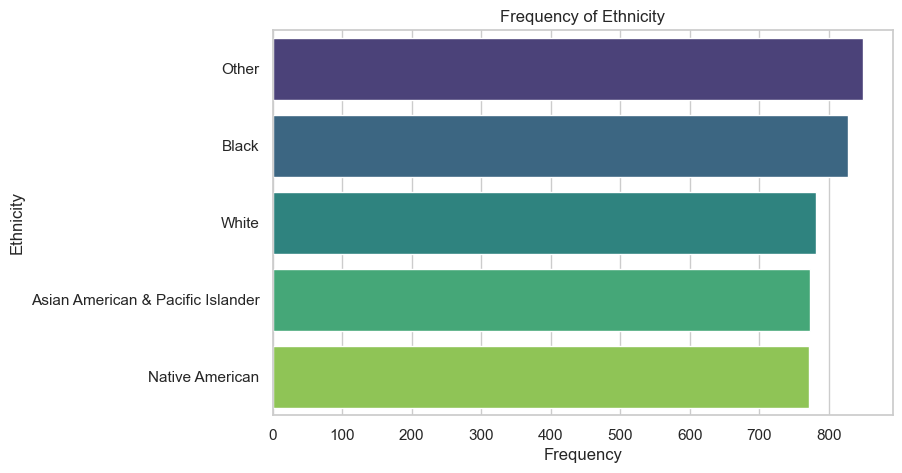

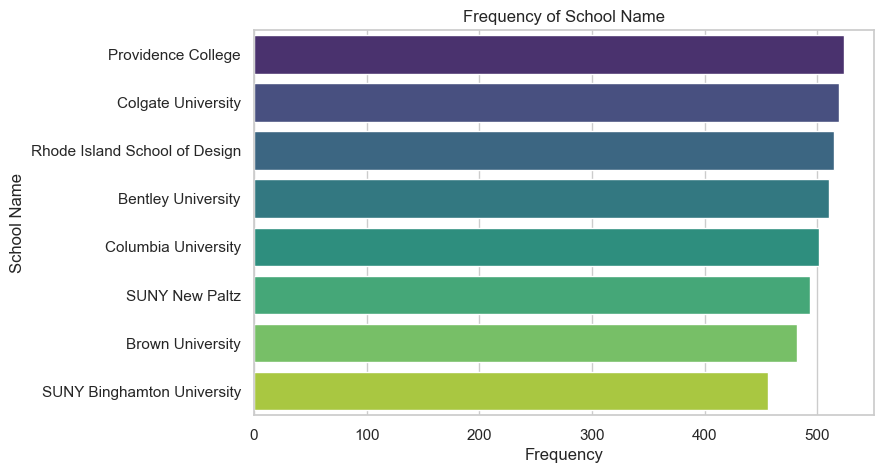

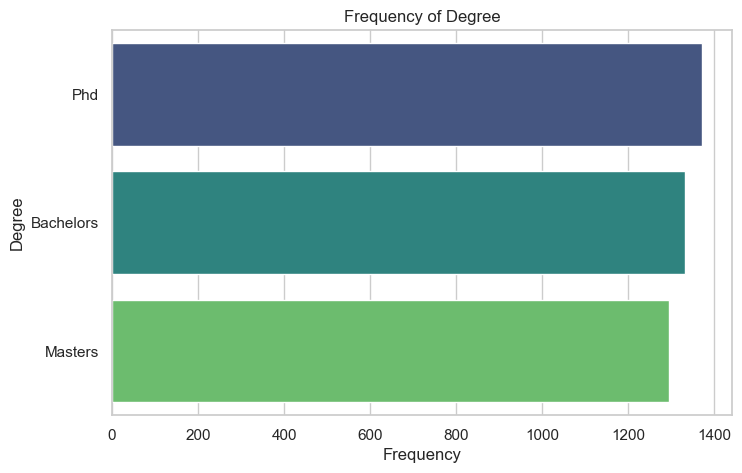

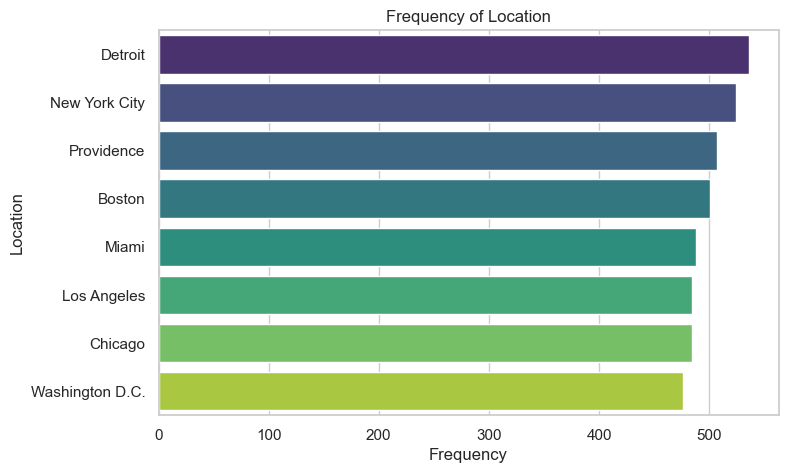

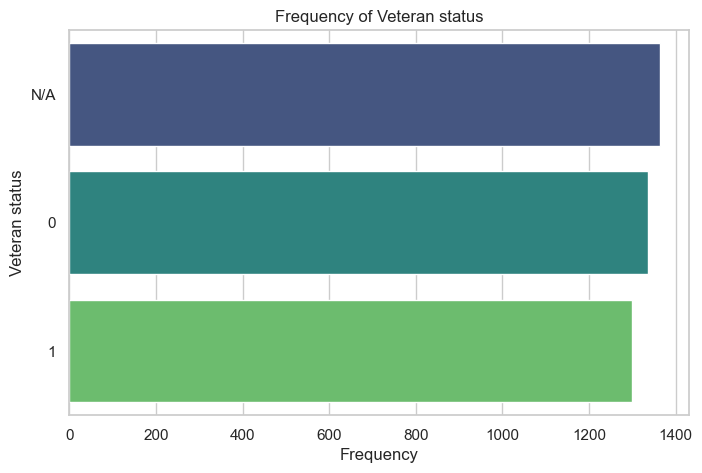

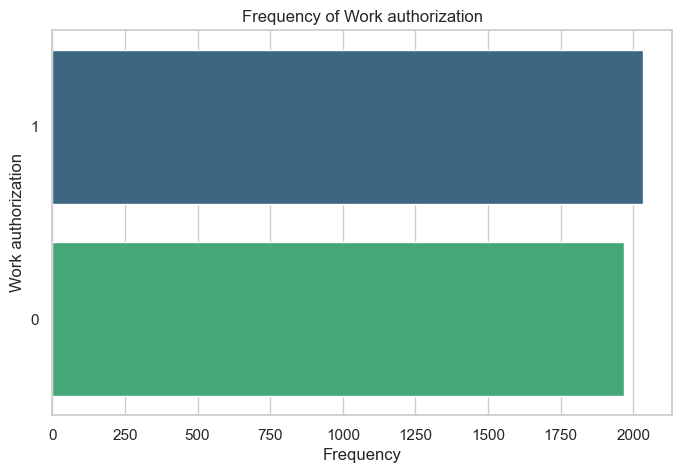

In [9]:
# Frequency of features
sns.set(style="whitegrid")

# Define the mapping for the 'Ethnicity' attribute
ethnicity_labels = {
    0: "White",
    1: "Black",
    2: "Native American",
    3: "Asian American & Pacific Islander",
    4: "Other"
}

# Attributes to plot
attributes = ['Gender', 'Disability', 'Ethnicity', 'School Name', 'Degree', 'Location', 'Veteran status', 'Work authorization']

# Create a plot for each attribute
for i in attributes:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, y=i, order=df[i].value_counts().index, palette='viridis')
    ax.set_title(f'Frequency of {i}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel(i)

    # If plotting 'Ethnicity', modify the y-axis labels
    if i == 'Ethnicity':
        # Get the current labels
        labels = [item.get_text() for item in ax.get_yticklabels()]
        # Set new labels based on the ethnicity_labels mapping
        new_labels = [ethnicity_labels[int(lbl)] for lbl in labels]
        ax.set_yticklabels(new_labels)

    plt.show()

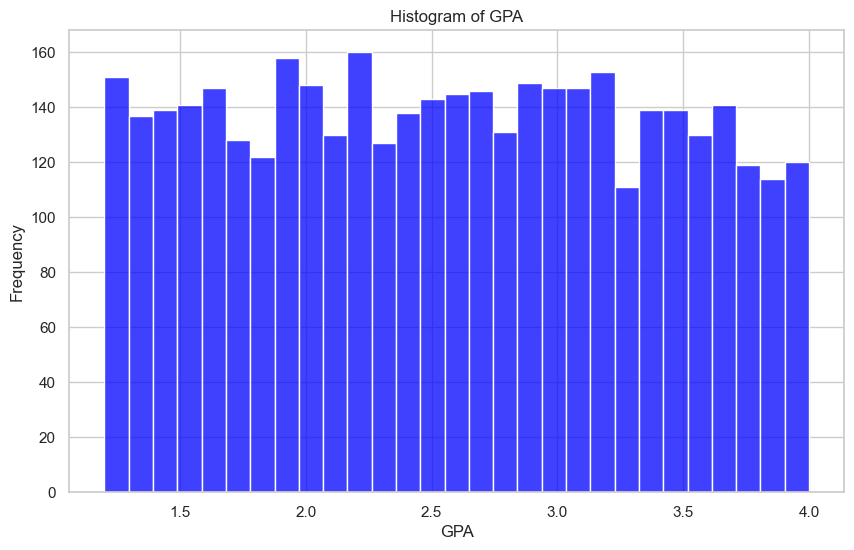

In [10]:
# Histogram of GPA
plt.figure(figsize=(10, 6))
sns.histplot(df['GPA'], kde=False, bins=29, color='blue')
plt.title('Histogram of GPA')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.show()

## Model Probing 

**Section Overview:** This section contains the code that is used to probe the Bank's algorithm using our synthetic data. The probing occurs by first passing the Resume Scorer API our dataset of 4000 candidates, then passing the Candidate Evaluator API the results from the Resume Scorer. We call this function twice on the same dataset of 4000 points in order to test for reproducibility. Additionally, we run this same process for a smaller, manually created dataset of 52 datapoints. 

In [11]:
def model_predict(data_original):
    
    data = data_original.copy()    
    data = data.fillna('N/A')

    # Specific conversion for numeric columns that need to be displayed as integers (no decimals)
    columns_to_convert = ['Veteran status', 'Work authorization', 'Disability', 'Ethnicity']
    for col in columns_to_convert:
        if col in data.columns:
            data[col] = data[col].apply(lambda x: str(int(x)) if x != 'N/A' else 'N/A')

    # Format GPA with two decimal places
    if 'GPA' in data.columns:
        data['GPA'] = data['GPA'].apply(lambda x: f"{x:.2f}" if x != 'N/A' else 'N/A')
    
    data = data.to_dict(orient='records')
    # Serialize the input data to JSON
    dataset = json.dumps(data)
    
    # Define the headers for JSON content type
    headers = {'Content-Type': 'application/json'}
    
    # Call the first API - resume scorer
    resume_url = 'https://jennjwang.pythonanywhere.com'
    resume_response = requests.post(resume_url, data=dataset, headers=headers)
    
    if not resume_response.ok:
        print("Error:", resume_response.status_code)
        return None
    
    try:
        resume_response_data = json.loads(resume_response.text)
        resume_predictions = json.loads(resume_response_data['prediction'])
        resume_score_map = {item['applicant_id']: item['score'] for item in resume_predictions}
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        return None
    

    # Update the input data with the resume score
    for applicant in data:
        applicant_id = str(applicant['Applicant ID'])
        applicant['Resume score'] = resume_score_map.get(applicant_id, 0)
    
    # Serialize the updated data for the next API call
    updated_dataset = json.dumps(data)    

    # Call the second API - candidate scorer
    candidate_url = 'https://heonlee.pythonanywhere.com'
    candidate_response = requests.post(candidate_url, data=updated_dataset, headers=headers)
    
    if not candidate_response.ok:
        print("Error:", candidate_response.status_code)
        return None
    
    try:
        candidate_response_data = json.loads(candidate_response.text)
        final_predictions = json.loads(candidate_response_data['prediction'])
        final_score_map = {item['applicant_id']: item['prediction'] for item in final_predictions}
    except json.JSONDecodeError as e:
        print("Error decoding JSON for the second API:", e)
        return None
    
    
    for applicant in data:
        applicant_id = str(applicant['Applicant ID'])
        applicant['Interview prediction'] = final_score_map.get(applicant_id, 0)
        
    results = pd.DataFrame(data)
    results['GPA'] = results['GPA'].astype(float)
    results['Resume score'] = results['Resume score'].astype(float)
    results['Interview prediction'] = results['Interview prediction'].astype(int)
    
    return results

In [12]:
# THIS PROCESS WAS REPEATED 4 TIMES - 2 TIMES FOR THE 4000 DATAPOINT FILE AND 2 TIMES FOR THE 52 DATAPOINT FILE 
df = pd.read_csv('../data/candidate_data_4000.csv')
df_prediction = model_predict(df)
df_prediction

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,...,Start 1,End 1,Role 2,Start 2,End 2,Role 3,Start 3,End 3,Resume score,Interview prediction
0,1,Rhode Island School of Design,3.1,Bachelors,Miami,M,1,0,0,2,...,7/16,7/22,Junior SWE,11/19,11/22,Senior SWE,12/21,12/22,8.40,1
1,2,Bentley University,1.9,Phd,New York City,N/A,0,0,1,0,...,11/13,11/18,ML Engineer,11/14,12/14,N/A,N/A,N/A,4.58,0
2,3,SUNY New Paltz,1.7,Masters,Washington D.C.,M,1,1,1,1,...,4/22,6/22,N/A,N/A,N/A,N/A,N/A,N/A,9.38,1
3,4,Brown University,2.8,Bachelors,Los Angeles,F,1,0,1,2,...,6/22,11/22,Lawyer,1/12,4/12,Lawyer,8/13,8/14,4.54,0
4,5,SUNY Binghamton University,2.8,Masters,Los Angeles,N/A,1,1,N/A,4,...,6/11,N/A,Junior SWE,6/10,7/10,Junior SWE,7/23,10/23,4.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,Rhode Island School of Design,2.3,Masters,Detroit,F,1,0,N/A,0,...,3/15,3/18,Lawyer,5/21,5/22,N/A,N/A,N/A,6.97,0
3996,3997,SUNY Binghamton University,1.6,Phd,Providence,N/A,0,0,N/A,0,...,10/17,10/18,Data scientist,5/21,5/22,Junior SWE,5/16,5/22,4.58,0
3997,3998,SUNY New Paltz,1.2,Bachelors,New York City,F,0,1,N/A,4,...,8/10,8/17,N/A,N/A,N/A,N/A,N/A,N/A,5.23,0
3998,3999,Brown University,1.8,Bachelors,Washington D.C.,N/A,0,1,1,4,...,1/16,1/20,Chef,9/11,9/13,Senior SWE,9/14,9/22,4.46,0


In [13]:
# # save data to local drive
# csv_file_path = '../results/candidate_data_4000_res_1.csv'  
# df_prediction.to_csv(csv_file_path, index=False)

## Evaluate Model - Large Dataset 

**Section Overview:** In this section we use the results of our model probing for the 4000 datapoint set to analyze the Bank's hiring algorithm for potential sources of bias. In order to conduct this analysis, we calculate various fairness metrics and statical measures. A detailed overview of our results can be found in the Audit Report published with this repo.

In [14]:
df_prediction_1 = pd.read_csv('../results/candidate_data_4000_res_1.csv')
df_prediction_2 = pd.read_csv('../results/candidate_data_4000_res_2.csv')

In [15]:
# Statistical Parity Difference
def spd(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Statistical Parity Difference (SPD) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - spd (float): Statistical Parity Difference between majority and minority classes.
    """
    predicted_labels = pd.to_numeric(predicted_labels)
    predicted_labels_series = pd.Series(predicted_labels, index=dataset.index)
    majority = dataset[dataset[sensitive_attribute] == majority_class]
    minority = dataset[dataset[sensitive_attribute] == minority_class]

    p_majority = predicted_labels_series[majority.index].mean()
    p_minority = predicted_labels_series[minority.index].mean()

    spd_val =  p_minority - p_majority
    return spd_val

In [16]:
# Disparate Impact
def di(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Disparate Impact (DI) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - di (float): Disparate Impact between majority and minority classes.
    """
    predicted_labels = pd.to_numeric(predicted_labels)
    predicted_labels_series = pd.Series(predicted_labels, index=dataset.index)
    majority = dataset[dataset[sensitive_attribute] == majority_class]
    minority = dataset[dataset[sensitive_attribute] == minority_class]

    p_majority = predicted_labels_series[majority.index].mean()
    p_minority = predicted_labels_series[minority.index].mean()

    di_val = p_minority / p_majority
    return di_val

In [17]:
# spd for current dataset
"""
Range: The range of SPD is [-1, 1]. 
A value of -1 indicates that all favorable outcomes are allocated to the majority group, 
whereas a value of 1 indicates that all favorable outcomes are allocated to the minority group. 
Perfect Fairness: A value of 0 indicates perfect fairness, 
meaning the probability of receiving a favorable outcome is equal for both the majority and minority groups.
"""

dfs_spd = {'df_prediction_1': df_prediction_1, 'df_prediction_2': df_prediction_2}

print("SPD on gender:")
for name, df in dfs_spd.items():
    res = spd("Gender", df, df["Interview prediction"], "M", "F")
    print(f"Statistical Parity Difference (SPD) of {name} is {res}")
    
print("SPD on ethnicity:")
for name, df in dfs_spd.items():
    res = spd("Ethnicity", df, df["Interview prediction"], 0, 1)
    print(f"Statistical Parity Difference (SPD) of {name} is {res}")

SPD on gender:
Statistical Parity Difference (SPD) of df_prediction_1 is -0.15909978216600637
Statistical Parity Difference (SPD) of df_prediction_2 is -0.15439816149883986
SPD on ethnicity:
Statistical Parity Difference (SPD) of df_prediction_1 is 0.010939994147583065
Statistical Parity Difference (SPD) of df_prediction_2 is 0.000981595851905992


In [18]:
# di for current dataset
"""
Range: DI is a ratio, so its range is [0, ∞). 
A value of 0 indicates extreme bias against the minority group, 
and a very high value indicates extreme bias against the majority group. 
Perfect Fairness: A DI of 1 (or close to 1) represents perfect fairness, 
suggesting that the probability of receiving a favorable outcome are equal for both groups.
"""

dfs_di = {'df_prediction_1': df_prediction_1, 'df_prediction_2': df_prediction_2}

print("DI on gender:")
for name, df in dfs_di.items():
    res = di("Gender", df, df["Interview prediction"], "M", "F")
    print(f"Statistical Parity Difference (DI) of {name} is {res}")
    
print("DI on gender:")
for name, df in dfs_spd.items():
    res = di("Ethnicity", df, df["Interview prediction"], 0, 1)
    print(f"Statistical Parity Difference (DI) of {name} is {res}")

DI on gender:
Statistical Parity Difference (DI) of df_prediction_1 is 0.5826787459851975
Statistical Parity Difference (DI) of df_prediction_2 is 0.5842884531538365
DI on gender:
Statistical Parity Difference (DI) of df_prediction_1 is 1.0562114172977788
Statistical Parity Difference (DI) of df_prediction_2 is 1.0049142715406318


In [19]:
# RM (Reproducibility Metric)
resume_score_1 = df_prediction_1['Resume score']
resume_score_2 =df_prediction_2['Resume score']

differences = abs(df_prediction_1['Resume score'] - df_prediction_2['Resume score'])
total_difference = differences.sum()
rm = total_difference / len(df_prediction_1)
print(f"rm score is {rm}")
print(f"This means the average resume score difference for the same candidate in two runs is {rm}")

rm score is 3.35412
This means the average resume score difference for the same candidate in two runs is 3.35412


In [20]:
# mean and standard deviation
mean_score_1 = resume_score_1.mean()
std_score_1 = resume_score_1.std()

mean_score_2 = resume_score_2.mean()
std_score_2 = resume_score_2.std()

# Print the results
print(f"Mean of 'Resume score' in df_prediction_1: {mean_score_1:.2f}")
print(f"Standard Deviation of 'Resume score' in df_prediction_1: {std_score_1:.2f}")
print(f"Mean of 'Resume score' in df_prediction_2: {mean_score_2:.2f}")
print(f"Standard Deviation of 'Resume score' in df_prediction_2: {std_score_2:.2f}")

Mean of 'Resume score' in df_prediction_1: 5.06
Standard Deviation of 'Resume score' in df_prediction_1: 2.90
Mean of 'Resume score' in df_prediction_2: 5.07
Standard Deviation of 'Resume score' in df_prediction_2: 2.90


In [21]:
# confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    n = len(data)
    interval = sem * stats.t.ppf((1 + confidence) / 2., n-1)  # T-distribution multiplier for 95% CI
    return (mean - interval, mean + interval)

# Calculate the confidence interval for 'Resume score' in both datasets
ci_score_1 = calculate_confidence_interval(resume_score_1)
ci_score_2 = calculate_confidence_interval(resume_score_2)

print(f"95% Confidence Interval for 'Resume score' in df_prediction_1: {ci_score_1[0]:.2f} to {ci_score_1[1]:.2f}")
print(f"95% Confidence Interval for 'Resume score' in df_prediction_2: {ci_score_2[0]:.2f} to {ci_score_2[1]:.2f}")

95% Confidence Interval for 'Resume score' in df_prediction_1: 4.97 to 5.15
95% Confidence Interval for 'Resume score' in df_prediction_2: 4.98 to 5.16


In [22]:
is_interview_1 = df_prediction_1['Interview prediction']
is_interview_2 = df_prediction_2['Interview prediction']

interview_getting_rate = (sum(is_interview_1) + sum(is_interview_2))/(2*len(is_interview_1))

print("The rate of getting an interview of Bold Bank is:",interview_getting_rate)

The rate of getting an interview of Bold Bank is: 0.19925


## Because the rate of getting an interview is approximately 20%, we are creating labels based on the assumption that candidates with a resume score over 8 could get an interview

Accuracy of df_prediction_1: 0.68


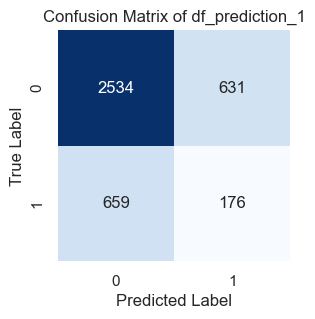

--------------------------------------------------
Accuracy of df_prediction_2: 0.67


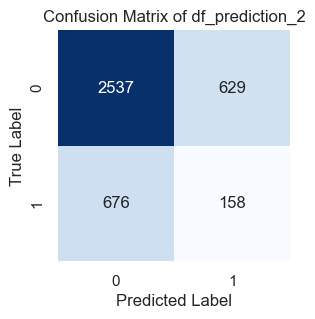

--------------------------------------------------


In [23]:
"""
Since the interview getting rate is ~20%, 
we assume that candidates with resume score over 8 could get an interview
"""

df_prediction_1['label'] = np.where(df_prediction_1['Resume score'] >= 8, 1, 0)
df_prediction_2['label'] = np.where(df_prediction_2['Resume score'] >= 8, 1, 0)


dfs = {'df_prediction_1': df_prediction_1, 'df_prediction_2': df_prediction_2}

for name, df in dfs.items():
    true_labels = df['label']  # Assuming 'label' column is your true labels
    predicted_labels = df['Interview prediction']  # Prediction results
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)

    print(f"Accuracy of {name}: {accuracy:.2f}")
    
    
    # Plotting the confusion matrix
    plt.figure(figsize=(3, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix of {name}")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print("-" * 50)

In [24]:
# Equal Opportunity Difference (EOD)
def eod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class):
    """
    Calculate the Equal Opportunity Difference (EOD) measure.

    Parameters:
    - sensitive_attribute: The column name of the sensitive attribute in the dataset.
    - predictions: Predictions made by the model.
    - dataset: The dataset containing the sensitive attribute and the outcome variable.
    - outcome_variable: The column name of the outcome variable in the dataset.
    - majority_class: The majority class label.
    - minority_class: The minority class label.

    Returns:
    - eod_value: The Equal Opportunity Difference measure.
    """
    # TODO: Compute the eod value
    predictions_series = pd.Series(predictions, index=dataset.index)
    positive_instances = dataset[true_labels == 1]

    # Use .loc to align with the DataFrame's index
    majority = positive_instances.loc[dataset[sensitive_attribute] == majority_class]
    minority = positive_instances.loc[dataset[sensitive_attribute] == minority_class]

    p_majority = predictions_series.loc[majority.index].mean()
    p_minority = predictions_series.loc[minority.index].mean()

    eod_value = p_minority - p_majority
    return eod_value

In [25]:
# Average Absolute Odds Difference (AAOD)
def aaod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class):
    """
    Calculate the Average Absolute Odds Difference (AAOD) to measure bias.

    Parameters:
    - sensitive_attribute (str): The name of the sensitive attribute in the dataset.
    - predictions (pd.Series): The predicted values.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute, predictions, and outcome variable.
    - outcome_variable (str): The name of the outcome variable in the dataset.
    - majority_class (int): The label of the majority class.
    - minority_class (int): The label of the minority class.

    Returns:
    - float: The calculated Average Absolute Odds Difference (AAOD).
    """
    # TODO: Compute the aaod value
    def tpr_fpr_calculation(group):
        TP = ((predictions == 1) & (true_labels == 1) & group).sum()
        FP = ((predictions == 1) & (true_labels == 0) & group).sum()
        TN = ((predictions == 0) & (true_labels == 0) & group).sum()
        FN = ((predictions == 0) & (true_labels == 1) & group).sum()

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        return FPR, TPR

    majority_group = dataset[sensitive_attribute] == majority_class
    minority_group = dataset[sensitive_attribute] == minority_class

    FPR_majority, TPR_majority = tpr_fpr_calculation(majority_group)
    FPR_minority, TPR_minority = tpr_fpr_calculation(minority_group)

    aaod_value = 0.5 * (abs(FPR_minority - FPR_majority) + abs(TPR_minority - TPR_majority))
    return aaod_value

In [26]:
# eod

"""Range: The range of SPD is [-1, 1]. 
A value of -1 indicates that all favorable outcomes are allocated to the majority group, 
whereas a value of 1 indicates that all favorable outcomes are allocated to the minority group.
Perfect Fairness: An EOD of 0 indicates perfect fairness, implying that both groups have an equal 
probability of receiving a favorable outcome when the true condition is positive."""

dfs_eod = {'df_prediction_1': df_prediction_1, 'df_prediction_2': df_prediction_2}

for name, df in dfs_eod.items(): 
    eod_score = eod('Gender', df['Interview prediction'], df, df['label'], 'M','F')
    print(f"Equal Opportunity Difference (EOD) Score of {name}: {eod_score}")

Equal Opportunity Difference (EOD) Score of df_prediction_1: -0.09901393831553973
Equal Opportunity Difference (EOD) Score of df_prediction_2: -0.10192612398494749


In [27]:
# aaod

"""
Range: The range of AAOD is also [−1,1]. 
A value of -1 indicates extreme bias in one direction, 
whereas a value of 1 indicates extreme bias in the opposite direction. 
Perfect Fairness: An AAOD of 0 indicates perfect fairness, 
meaning that both the false positive rate and the true positive rate are equal across groups.
"""

dfs_aaod = {'df_prediction_1': df_prediction_1, 'df_prediction_2': df_prediction_2}


for name, df in dfs_aaod.items():
    aaod_score = aaod('Gender', df['Interview prediction'], df, df['label'], 'M','F')
    print(f"Average Absolute Odds Difference (AAOD) Score of {name}: {aaod_score}")

Average Absolute Odds Difference (AAOD) Score of df_prediction_1: 0.13712289465120092
Average Absolute Odds Difference (AAOD) Score of df_prediction_2: 0.13507383094860353


## Model Evaluation - Small Dataset

**Section Overview:** In this section we use the results of our model probing for the 52 datapoint set to analyze the Bank's hiring algorithm for potential sources of bias. In order to conduct this analysis, we calculate various fairness metrics and statical measures. A detailed overview of our results can be found in the Audit Report published with this repo.

In [28]:
data1 = pd.read_csv('../results/candidate_data_manual_res_1.csv')
data2 = pd.read_csv('../results/candidate_data_manual_res_2.csv')

#data1.head(), data2.head()

In [29]:
#calculate DI and SPD scores
dfs_manual = {'df_prediction_1': data1, 'df_prediction_2': data2}

#####################gender

print("DI on gender:")
for name, df in dfs_manual.items():
    res = di("Gender", df, df["Interview prediction"], "M", "F")
    print(f"Statistical Parity Difference (DI) of {name} is {res}")
    
print("DI on gender:")
for name, df in dfs_spd.items():
    res = di("Ethnicity", df, df["Interview prediction"], 0, 1)
    print(f"Statistical Parity Difference (DI) of {name} is {res}")
    
print("-"*50)
####################ethnicity    
    
print("SPD on gender:")
for name, df in dfs_manual.items():
    res = spd("Gender", df, df["Interview prediction"], "M", "F")
    print(f"Statistical Parity Difference (SPD) of {name} is {res}")
    
print("SPD on ethnicity:")
for name, df in dfs_spd.items():
    res = spd("Ethnicity", df, df["Interview prediction"], 0, 1)
    print(f"Statistical Parity Difference (SPD) of {name} is {res}")

DI on gender:
Statistical Parity Difference (DI) of df_prediction_1 is 0.5294117647058824
Statistical Parity Difference (DI) of df_prediction_2 is 0.35294117647058826
DI on gender:
Statistical Parity Difference (DI) of df_prediction_1 is 1.0562114172977788
Statistical Parity Difference (DI) of df_prediction_2 is 1.0049142715406318
--------------------------------------------------
SPD on gender:
Statistical Parity Difference (SPD) of df_prediction_1 is -0.3076923076923077
Statistical Parity Difference (SPD) of df_prediction_2 is -0.4230769230769231
SPD on ethnicity:
Statistical Parity Difference (SPD) of df_prediction_1 is 0.010939994147583065
Statistical Parity Difference (SPD) of df_prediction_2 is 0.000981595851905992


In [30]:
# RM (Reproducibility Metric)
resume_score_1 = data1['Resume score']
resume_score_2 =data2['Resume score']

differences = abs(data1['Resume score'] - data2['Resume score'])
total_difference = differences.sum()
rm = total_difference / len(data1)
print(f"rm score is {rm}")
print(f"This means the average resume score difference for the same candidate in two runs is {rm}")

rm score is 3.4709615384615384
This means the average resume score difference for the same candidate in two runs is 3.4709615384615384


In [31]:
# mean and standard deviation
mean_score_1 = resume_score_1.mean()
std_score_1 = resume_score_1.std()

mean_score_2 = resume_score_2.mean()
std_score_2 = resume_score_2.std()

# Print the results
print(f"Mean of 'Resume score' in df_prediction_1: {mean_score_1:.2f}")
print(f"Standard Deviation of 'Resume score' in df_prediction_1: {std_score_1:.2f}")
print(f"Mean of 'Resume score' in df_prediction_2: {mean_score_2:.2f}")
print(f"Standard Deviation of 'Resume score' in df_prediction_2: {std_score_2:.2f}")

Mean of 'Resume score' in df_prediction_1: 4.46
Standard Deviation of 'Resume score' in df_prediction_1: 3.03
Mean of 'Resume score' in df_prediction_2: 5.43
Standard Deviation of 'Resume score' in df_prediction_2: 2.81


In [32]:
# confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    n = len(data)
    interval = sem * stats.t.ppf((1 + confidence) / 2., n-1)  # T-distribution multiplier for 95% CI
    return (mean - interval, mean + interval)

# Calculate the confidence interval for 'Resume score' in both datasets
ci_score_1 = calculate_confidence_interval(resume_score_1)
ci_score_2 = calculate_confidence_interval(resume_score_2)

print(f"95% Confidence Interval for 'Resume score' in df_prediction_1: {ci_score_1[0]:.2f} to {ci_score_1[1]:.2f}")
print(f"95% Confidence Interval for 'Resume score' in df_prediction_2: {ci_score_2[0]:.2f} to {ci_score_2[1]:.2f}")

95% Confidence Interval for 'Resume score' in df_prediction_1: 3.62 to 5.30
95% Confidence Interval for 'Resume score' in df_prediction_2: 4.65 to 6.21


## Hypothesis testing

**Section Overview:** Finally, in this section we could hypothesis tests to evaluate the statistical significance of our audit findings.

In [33]:
merged_data = pd.concat([data1, data2])

# Split data by gender
male_data = merged_data[merged_data['Gender'] == 'M']
female_data = merged_data[merged_data['Gender'] == 'F']

# Overview of split datasets for 'Resume score' and 'Interview prediction'
male_resume_scores = male_data['Resume score']
female_resume_scores = female_data['Resume score']
male_interview_predictions = male_data['Interview prediction']
female_interview_predictions = female_data['Interview prediction']

print(male_resume_scores.describe())
print(female_resume_scores.describe())
print("-"*50)
print(male_interview_predictions.value_counts())
print(female_interview_predictions.value_counts())

count    52.000000
mean      5.081538
std       3.072707
min       0.060000
25%       3.002500
50%       4.585000
75%       8.192500
max       9.930000
Name: Resume score, dtype: float64
count    52.000000
mean      4.810962
std       2.838704
min       0.140000
25%       2.665000
50%       4.505000
75%       7.462500
max       9.990000
Name: Resume score, dtype: float64
--------------------------------------------------
1    34
0    18
Name: Interview prediction, dtype: int64
0    37
1    15
Name: Interview prediction, dtype: int64


In [34]:
"""
The t-test: asks whether the average (mean) performance 
(as measured by resume scores) differs between genders.

The chi-square test: asks whether the likelihood of a particular categorical 
outcome (passing or failing the interview) is different between genders.
"""

# Perform two-sample t-test on Resume scores
t_stat, p_value_resume = ttest_ind(male_resume_scores, female_resume_scores, equal_var=False)

# Interpret and print the result for Resume scores
print(f"P value is {p_value_resume}")
if p_value_resume < 0.05:
    print("There is a statistically significant difference in resume scores between male and female candidates.")
else:
    print("There is no statistically significant difference in resume scores between male and female candidates.")

# Create a contingency table for Interview predictions
contingency_table = pd.crosstab(merged_data['Gender'], merged_data['Interview prediction'])

# Perform chi-square test on Interview predictions
chi2_stat, p_value_interview, dof, expected = chi2_contingency(contingency_table)

# Interpret and print the result for Interview predictions
print(f"P value is {p_value_interview}")
if p_value_interview < 0.05:
    print("There is a statistically significant difference in interview predictions between male and female candidates.")
else:
    print("There is no statistically significant difference in interview predictions between male and female candidates.")


P value is 0.6419164328167465
There is no statistically significant difference in resume scores between male and female candidates.
P value is 0.0004062655737454636
There is a statistically significant difference in interview predictions between male and female candidates.
